### Managing a portfolio

Some code designed to give me a better overview of my investments over time. <br>
Aside from giving me some metrics (like a position's performance), I wanted something that could tell me <br>
what I need to report on my tax statements, simply by looking at a transaction history. 


This is just a conceptual foundation. I'll be trying to pour this into some sort of web app.

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import requests
import json

from datetime import datetime
from dateutil import relativedelta
from collections import namedtuple
from forex_python.converter import CurrencyRates
from pandas_datareader.data import get_quote_yahoo

c = CurrencyRates()
%matplotlib inline

In [2]:
""" helper functions """

def get_fx(base, symbol, date):
    """ writing our own currency converter function, as a backup for forex-python 
        (it has been down before)
        
        https://ratesapi.io/documentation/
    """
    
    try:
        return c.get_rate(base.upper(), symbol.upper(), date)
    except:
        
        # Assuming we will be feeding the datetime object from the pandas dataframe
        try:
            date = date.strftime('%Y-%m-%d')
        except:
            raise TypeError('The date argument needs a datetime object')

        # Making the request and isolating the fx rate
        URL = 'https://api.ratesapi.io/api/{}?base={}&symbols={}'.format(date, 
                                                                         base.upper(), 
                                                                         symbol.upper())
        r = requests.get(url=URL)
        data = r.json()
        rate = data['rates']

        return next(iter(rate.values()))
    
def get_tarif(amount):
    """ Added acquisition cost/tarif when buying/selling 
        
        In our case, the bank requires a minimum of 30€ per transaction, 
        but charges more as the amounts go up, although diminishingly so as the amount scales.
    """

    tarifs = {
        125000: 0.0025, 
        50000: 0.00375,
        0: 0.005
    }

    for threshold, tarif in tarifs.items():
        if abs(amount) >= threshold:
            return max(abs(amount) * tarif, 30) * -1
            break
            
def get_months_difference(later_date, earlier_date):
    r = relativedelta.relativedelta(later_date, earlier_date)
    return r.years * 12 + r.months

def get_fees(sale_date, purchase_date):
    pass
                        
def get_stock_price(ticker):
    """ Returns the latest price of a stock """
    
    stock = get_quote_yahoo(ticker)
    return stock['price'].iloc[0]

Most brokers/banks will have costs associated with transacting (the house always wins!) <br>
In our case, the bank requires a minimum of 30€ per transaction, but charges more as the amounts go up, <br>
although diminishingly so as the amount scales.

6000.0

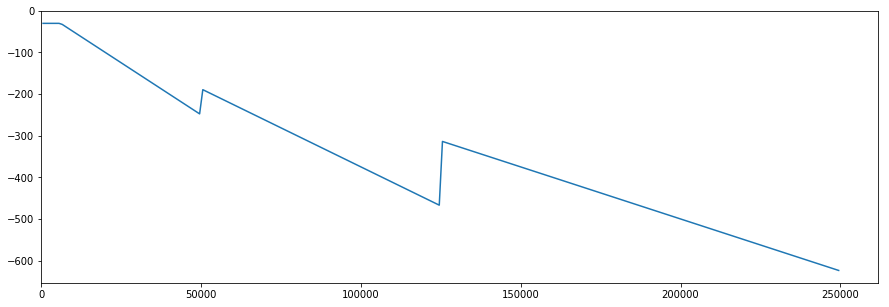

In [3]:
""" Visualising the tarifs """

amounts = np.arange(500, 250000, 1000)
tarifs = np.array(list(map(get_tarif, amounts)))

f, ax = plt.subplots(1, figsize=(15,5))
ax.plot(amounts, tarifs)
ax.set_xlim(0)

# Tarifs start to increase at the 6000€ mark
30 / 0.005

Let's load in our transaction history

In [4]:
# Reading our transaction history
thr = pd.read_csv('transaction_history.csv')

# Forex_python's CurrencyRates.get_rate requires a datetime object
thr['trade_date'] = pd.to_datetime(thr['trade_date'], format='%d/%m/%Y')

# Making sure the dataframe is chronologically ordered
thr = thr.sort_values(by='trade_date', ascending=True)
thr = thr.reset_index(drop=True)
thr.index += 1

# Fetch the fx rates
thr['fx_to_eur'] = thr.apply(lambda row: get_fx(base=row['currency'], symbol='EUR', date=row['trade_date']), axis=1)

# The metrics that matter for taxes:
thr['worth_eur'] = thr['quantity'] * thr['price'] * thr['fx_to_eur'] * -1

# Calculating tarifs and adding them to the cash movement
thr['tarif'] = thr.apply(lambda row: get_tarif(row['worth_eur']), axis=1)
thr['cash_eur'] = thr['worth_eur'] + thr['tarif']

# Rearranging the columns
cols = [col for col in thr if col not in ['cash_eur', 'tarif']] + ['tarif', 'cash_eur']
thr = thr.reindex(columns=cols)
thr['fiscal_year'] = thr['trade_date'].dt.year

# Printing 
thr

,ticker,trade_date,transtype,quantity,price,currency,fx_to_eur,worth_eur,tarif,cash_eur,fiscal_year
1,TSLA,2016-12-14,BUY,13,200.60,USD,0.939496,-2450.018790,-30.000000,-2480.018790,2016
2,AAPL,2017-02-28,BUY,20,136.98,USD,0.943663,-2585.259979,-30.000000,-2615.259979,2017
3,ASML,2017-03-12,BUY,13,116.55,EUR,1.000000,-1515.150000,-30.000000,-1545.150000,2017
4,ALB,2017-03-24,BUY,19,105.54,USD,0.925497,-1855.863026,-30.000000,-1885.863026,2017
5,TSLA,2017-05-04,BUY,7,295.67,USD,0.915164,-1894.106342,-30.000000,-1924.106342,2017
6,TSLA,2017-08-02,BUY,10,317.19,USD,0.845380,-2681.460817,-30.000000,-2711.460817,2017
7,TSLA,2017-09-19,SELL,-13,376.57,USD,0.835282,4089.049449,-30.000000,4059.049449,2017
8,TSLA,2017-09-29,BUY,14,343.77,USD,0.847027,-4076.554295,-30.000000,-4106.554295,2017
9,TSLA,2017-11-02,BUY,10,300.00,USD,0.858738,-2576.212967,-30.000000,-2606.212967,2017
10,ALB,2017-11-08,SELL,-19,138.98,USD,0.862813,2278.360656,-30.000000,2248.360656,2017


#### Calculating total capital gains, irrespective of year or taxability.
Takes into account transaction costs, but not holding fees.

In [5]:
# Defining arguments for our Group By
aggs = {
    'trade_date': 'count',
    'quantity': 'sum',
    'tarif': 'sum',
    'cash_eur': 'sum'
}
cols = {
    'trade_date': 'transactions',
    'quantity': 'active_shares',
    'cash_eur': 'net_cash_eur'
}

# looking at the cumulative positions (realised capital gains/losses and current positions)
cap = thr.groupby(['ticker', 'currency']).agg(aggs).rename(columns=cols)

# Adding calculated columns
cap['stock_price'] = cap.apply(lambda row: get_stock_price(row.name[0]), axis=1)
cap['worth'] = cap['active_shares'] * cap['stock_price'] 
cap['current_fx_eur'] = cap.apply(lambda row: get_fx(base=row.name[1], symbol='EUR', date=datetime.now()), axis=1)
cap['worth_eur'] = cap['worth'] * cap['current_fx_eur']
cap['cap_gains_losses'] = cap['worth_eur'] + cap['net_cash_eur']

# Dropping those we don't need anymore
cap = cap.drop(['worth', 'current_fx_eur'], axis=1)

# Rounding values
#cap = cap.round(2)

# print our dataframe
cap

,,transactions,active_shares,tarif,net_cash_eur,stock_price,worth_eur,cap_gains_losses
ticker,currency,,,,,,,
AAPL,USD,5,0,-159.686002,2064.906500,197.00,0.000000,2064.906500
ALB,USD,2,0,-60.000000,362.497629,86.14,0.000000,362.497629
ASML,EUR,2,0,-60.000000,387.850000,201.39,0.000000,387.850000
NIO,USD,1,750,-30.000000,-3652.767857,5.36,3578.741209,-74.026648
NVDA,USD,1,39,-32.984598,-6629.904241,190.95,6629.618090,-0.286152
TSLA,USD,10,105,-300.000000,-25005.962035,274.96,25701.771567,695.809532


#### Calculating profit on each sale

    Strategy: 
        In order of priority: Minimize the amount going to taxes, then maximize capital gains.
    
    Approach:
        Run through timeline chronologically, adding positions to the portfolio state.
        When there is a sale:
            1) Isolate preceding buys of same ticker 
            2) Categorize:
                if > 6 months ago -> taxable = False
                if < 6 months ago -> = speculative income -> taxable = True
            3) Sort by taxable, purchasing price
            4) subtract sale units until 0, starting with > 6 months, lowest price
            5) update portfolio state so the next sale doesn't feed from wrong data


In [32]:
# Work in a new copy & sort chronologically per ticker
portfolio = thr.sort_values(by=['ticker', 'trade_date']).reset_index(drop=True)
portfolio.index += 1
portfolio = portfolio.drop(['cash_eur'], axis=1)

# Adding columns for our calculations
portfolio['taxable'] = np.nan

# Immutable container for each of our sales, which we will pour into a dataframe and groupby at a later time
Sale = namedtuple('Sale', ['ticker', 'year', 'taxable', 'units', 'buying_price', 
                           'selling_price', 'cap_eur', 'tarif', 'fees', 'performance'])

# Initiating some variables
sales, positions, remaining_portfolio =  [], [], []
current_ticker = portfolio.iloc[0].ticker


# Run through timeline chronologically for each ticker
for index, row in portfolio.iterrows():
       
    # Work on a blank slate when we hit a new ticker 
    if current_ticker != row.ticker and len(positions) > 0:
        remaining_portfolio.append([position for position in positions])
        positions.clear()
    
    # Purchases - adding to the positions
    if row.transtype == 'BUY':
        
        # Erase positions that are now 0 as a consequence of sales
        positions = [position for position in positions if position.quantity != 0]
        
        # Add new positions
        positions.append(row)
     
    # Sales - modifying the positions & logging a capital gain
    elif row.transtype == 'SELL':

        # Check which positions are taxable relative to the sale
        for position in positions:
            if position.ticker == row.ticker:
                if get_months_difference(row.trade_date, position.trade_date) >= 6:
                    position.taxable = False
                else:
                    position.taxable = True
        
        # Sort positions based on whether they are taxable and by price
        positions.sort(key=operator.itemgetter('taxable', 'price'))
        
        # Calculate the sale gains/losses over each position
        for position in positions:
            
            # The amount of units in the position that are subject to a sale
            units = min(position.quantity, abs(row.quantity))
                       
            # Capture sale data
            gain = (units * row.price * row.fx_to_eur) - (units * position.price * position.fx_to_eur)
            tarif_position = units / position.quantity * position.tarif
            tarif_sale = units / abs(row.quantity) * row.tarif 
            tarif = tarif_position + tarif_sale 
            
            # Calculating the performance of each sale, based on the after-tarif return on the investment
            perf =  (units * row.price * row.fx_to_eur) + tarif
            perf /= (units * position.price * position.fx_to_eur)
            perf -= 1
            perf *= 100
            
            # Log the sale
            sale = Sale(ticker=row.ticker,
                        year=row.fiscal_year,
                        taxable=position.taxable,
                        units=units,
                        buying_price=position.price,
                        selling_price=row.price,
                        cap_eur=gain,
                        tarif=tarif,
                        fees=0,
                        performance='{0:.2f}%'.format(perf))
            sales.append(sale)
            
            # Adjust the remaining units in the position and sale
            position.quantity, row.quantity = max(0, position.quantity + row.quantity), row.quantity + position.quantity
            
            # Recalculate the columns based on previous adjustment
            position.worth_eur = position.quantity * position.price * position.fx_to_eur * -1
            row.worth_eur = row.quantity * row.price * row.fx_to_eur * -1
            position.tarif -= tarif_position
            row.tarif -= tarif_sale
            
            # Erase positions that are now 0 as a consequence of the sale
            positions = [position for position in positions if position.quantity != 0]
            
            # Exit for loop if we have nothing to sell anymore
            if row.quantity == 0:
                break
    
    # If this was the last row in the dataset, append the last remaining positions (if there are any) 
    if index == len(portfolio):
        remaining_portfolio.append([position for position in positions if position.quantity != 0])
        positions.clear()
    
    # Feed ticker to the next iteration
    current_ticker = row.ticker

#### Summarizing metrics

    1) performance of every sale
    2) performance aggregated per ticker/year/taxability
    3a) the remaining active positions
    3b) and their average acquisition prices (what price you need to sell at to break even on the remainder of the position

In [33]:
""" Dataframe of every sale """
sales = pd.DataFrame(data=sales).sort_values(by=['year', 'ticker']).reset_index(drop=True)
sales

,ticker,year,taxable,units,buying_price,selling_price,cap_eur,tarif,fees,performance
0,ALB,2017,False,19,105.54,138.98,422.497629,-60.000000,0,19.53%
1,ASML,2017,False,13,116.55,151.00,447.850000,-60.000000,0,25.60%
2,TSLA,2017,False,13,200.60,376.57,1639.030659,-60.000000,0,64.45%
3,AAPL,2018,False,20,136.98,187.42,657.861668,-46.215608,0,23.66%
4,AAPL,2018,False,25,170.77,187.42,434.359880,-50.269510,0,10.61%
5,AAPL,2019,True,40,157.00,188.00,1132.370953,-63.200883,0,19.41%


In [28]:
""" Sales aggregated by Ticker, Year, and Taxability """

# Value columns
aggs = {
    'cap_eur': 'sum',
    'tarif': 'sum',
    'fees': 'sum'
}

# Building the dataframe
statement = sales.groupby(['ticker', 'year', 'taxable']).agg(aggs)
statement['cash_eur'] = statement.cap_eur + statement.tarif + statement.fees
statement = statement.round(2)

# Printing
statement

cap_eur  tarif  fees  cash_eur
ticker year taxable                                
AAPL   2018 False    1092.22 -96.49     0    995.74
       2019 True     1132.37 -63.20     0   1069.17
ALB    2017 False     422.50 -60.00     0    362.50
ASML   2017 False     447.85 -60.00     0    387.85
TSLA   2017 False    1639.03 -60.00     0   1579.03

In [31]:
""" Remaining positions """

# Loading the leftover positions into a dataframe
data = [obj for sublist in remaining_portfolio for obj in sublist]
pos = pd.DataFrame(data=data).drop(['transtype', 'taxable', 'fiscal_year'], axis=1)

# Calculating the current values
pos['current_price'] = pos.apply(lambda row: get_stock_price(row.ticker), axis=1)
pos['current_fx_eur'] = pos.apply(lambda row: get_fx(base=row.currency, symbol='EUR', date=datetime.now()), axis=1)
pos['current_worth_eur'] = pos.quantity * pos.current_price * pos.current_fx_eur

# Current gain/loss per position
pos['cash_eur'] = pos.worth_eur + pos.tarif + pos.current_worth_eur
pos['performance'] = (pos.current_worth_eur / abs(pos.worth_eur + pos.tarif) - 1) * 100

# Rounding the final results
pos = pos.round(2)

# Layout 
pos.performance = pd.Series(['{0:.2f}%'.format(p) for p in pos.performance], index = pos.index)

# Printing
pos

,ticker,trade_date,quantity,price,currency,fx_to_eur,worth_eur,tarif,current_price,current_fx_eur,current_worth_eur,cash_eur,performance
10,NIO,2019-04-02,750,5.41,USD,0.89,-3622.77,-30.00,5.36,0.89,3578.74,-74.03,-2.03%
11,NVDA,2019-04-02,39,189.45,USD,0.89,-6596.92,-32.98,190.95,0.89,6629.62,-0.29,-0.00%
13,TSLA,2017-05-04,7,295.67,USD,0.92,-1894.11,-30.00,274.96,0.89,1713.45,-210.65,-10.95%
14,TSLA,2017-08-02,10,317.19,USD,0.85,-2681.46,-30.00,274.96,0.89,2447.79,-263.67,-9.72%
16,TSLA,2017-09-29,14,343.77,USD,0.85,-4076.55,-30.00,274.96,0.89,3426.90,-679.65,-16.55%
17,TSLA,2017-11-02,10,300.00,USD,0.86,-2576.21,-30.00,274.96,0.89,2447.79,-158.43,-6.08%
18,TSLA,2018-03-28,11,260.00,USD,0.81,-2306.82,-30.00,274.96,0.89,2692.57,355.74,15.22%
19,TSLA,2018-07-25,14,299.57,USD,0.86,-3587.66,-30.00,274.96,0.89,3426.90,-190.76,-5.27%
20,TSLA,2018-10-09,19,258.50,USD,0.87,-4295.15,-30.00,274.96,0.89,4650.80,325.65,7.53%
21,TSLA,2019-03-06,20,278.50,USD,0.88,-4927.02,-30.00,274.96,0.89,4895.58,-61.45,-1.24%


In [13]:
""" Average acquisition prices """

# Lambda function to compute the weighted average:
wa = lambda x: np.average(x, weights=pos.loc[x.index, 'quantity'])

# Use the lambda function below
aggs = {
    'quantity': 'sum',
    'price': {'weighted_average' : wa},
    'current_worth_eur': 'sum'
}

# Groupby and aggregate 
aap = pos.groupby(['ticker']).agg(aggs)
aap = aap.round(2)
aap

,quantity,price,current_worth_eur
,sum,weighted_average,sum
ticker,,,
NIO,750,5.41,3578.74
NVDA,39,189.45,6629.62
TSLA,105,291.33,25701.78
